# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [136]:
# import libraries
from sqlalchemy import create_engine
import sqlite3
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt

### NLP Packages ###
import nltk
nltk.download(['punkt','wordnet', 'stopwords'])
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

### ML Packages ###
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
# load data from database
engine = create_engine('sqlite:///InsertDatabaseName.db')
con = engine.connect()
df = pd.read_sql_table('InsertTableName', con=engine.connect())


### 2. Write a tokenization function to process your text data

In [49]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'


def tokenize(text):
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")
    text = re.sub(r'[^0-9a-zA-Z]', ' ', text)

    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)        

    return clean_tokens

In [105]:
df = df[df.message.map(tokenize).map(lambda x: True if len(x)!=0 else False)]
X = df.message
Y = df[df.columns[4:]]

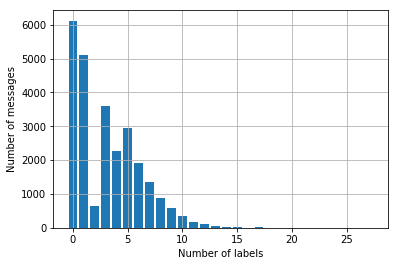

In [102]:
rowSums = Y.iloc[:, :].sum(axis=1)
plt.bar(rowSums.value_counts().keys(), rowSums.value_counts())
plt.xlabel('Number of labels')
plt.ylabel('Number of messages');
plt.grid('on')

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [110]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(KNeighborsClassifier(), n_jobs=-1))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [112]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ic_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
           n_jobs=-1))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [114]:
y_pred = pipeline.predict(X_test)

In [116]:
for i, col in enumerate(Y.columns):
    print(f'Class : {col}')
    target = y_test.values[:, i]
    pred = y_pred[:, i]
    target_names = [f'is {col}', f'is not {col}']
    print(classification_report(target, pred, target_names=target_names))

Class : related
                precision    recall  f1-score   support

    is related       0.57      0.43      0.49      1586
is not related       0.83      0.90      0.86      4914

   avg / total       0.76      0.78      0.77      6544

Class : request
                precision    recall  f1-score   support

    is request       0.91      0.94      0.93      5461
is not request       0.66      0.54      0.59      1083

   avg / total       0.87      0.88      0.87      6544

Class : offer
              precision    recall  f1-score   support

    is offer       0.99      1.00      1.00      6511
is not offer       0.00      0.00      0.00        33

 avg / total       0.99      0.99      0.99      6544

Class : aid_related
                    precision    recall  f1-score   support

    is aid_related       0.73      0.79      0.76      3882
is not aid_related       0.65      0.57      0.61      2662

       avg / total       0.70      0.70      0.70      6544

Class : medical_he

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 3, does not match size of target_names, 2
  .format(len(labels), len(target_names))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 1, does not match size of target_names, 2
  .format(len(labels), len(target_names))


### 6. Improve your model
Use grid search to find better parameters. 

In [132]:
for i in pipeline.get_params().keys():
    if 'clf' in i: 
        print("\t",i)

	 clf
	 clf__estimator__algorithm
	 clf__estimator__leaf_size
	 clf__estimator__metric
	 clf__estimator__metric_params
	 clf__estimator__n_jobs
	 clf__estimator__n_neighbors
	 clf__estimator__p
	 clf__estimator__weights
	 clf__estimator
	 clf__n_jobs


In [133]:
parameters = {'clf__estimator__n_neighbors': [5, 10, 15],
             'clf__estimator__weights': ['uniform', 'distance']}

cv = GridSearchCV(pipeline, param_grid=parameters)

In [134]:
cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ic_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
           n_jobs=-1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__estimator__n_neighbors': [5, 10, 15], 'clf__estimator__weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [135]:
cv.best_estimator_

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...c_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform'),
           n_jobs=-1))])

In [139]:
y_pred_cv = cv.predict(X_test)

In [140]:
for i, col in enumerate(Y.columns):
    print('=============================================')
    print(f'Class : {col}')
    target = y_test.values[:, i]
    pred_cv = y_pred_cv[:, i]
    pred = y_pred[:, i]
    target_names = [f'is {col}', f'is not {col}']
    print('=============================================')
    print(classification_report(target, pred, target_names=target_names))
    target_names = [f'is {col}_cv', f'is not {col}_cv']
    print('====================')
    print(classification_report(target, pred_cv, target_names=target_names))

Class : related
                precision    recall  f1-score   support

    is related       0.57      0.43      0.49      1586
is not related       0.83      0.90      0.86      4914

   avg / total       0.76      0.78      0.77      6544

                   precision    recall  f1-score   support

    is related_cv       0.60      0.47      0.53      1586
is not related_cv       0.84      0.90      0.87      4914

      avg / total       0.78      0.79      0.78      6544

Class : request
                precision    recall  f1-score   support

    is request       0.91      0.94      0.93      5461
is not request       0.66      0.54      0.59      1083

   avg / total       0.87      0.88      0.87      6544

                   precision    recall  f1-score   support

    is request_cv       0.90      0.97      0.93      5461
is not request_cv       0.75      0.47      0.58      1083

      avg / total       0.88      0.89      0.88      6544

Class : offer
              precisio

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 3, does not match size of target_names, 2
  .format(len(labels), len(target_names))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 1, does not match size of target_names, 2
  .format(len(labels), len(target_names))


               precision    recall  f1-score   support

    is floods       0.93      0.99      0.96      5986
is not floods       0.71      0.22      0.33       558

  avg / total       0.91      0.93      0.91      6544

                  precision    recall  f1-score   support

    is floods_cv       0.93      1.00      0.96      5986
is not floods_cv       0.84      0.14      0.25       558

     avg / total       0.92      0.92      0.90      6544

Class : storm
              precision    recall  f1-score   support

    is storm       0.93      0.99      0.96      5922
is not storm       0.69      0.32      0.44       622

 avg / total       0.91      0.92      0.91      6544

                 precision    recall  f1-score   support

    is storm_cv       0.92      0.99      0.96      5922
is not storm_cv       0.74      0.23      0.35       622

    avg / total       0.91      0.92      0.90      6544

Class : fire
             precision    recall  f1-score   support

    is fire

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [141]:
forest_pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(), n_jobs=-1))
])

In [142]:
forest_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ob_score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=-1))])

In [143]:
y_pred_rf = forest_pipeline.predict(X_test)

In [147]:
for i, col in enumerate(Y.columns):
    print('=============================================')
    print(f'Class : {col}')
    target = y_test.values[:, i]
    pred_cv = y_pred_cv[:, i]
    pred = y_pred[:, i]
    pred_rf = y_pred_rf[:, i]
    target_names = [f'is {col}', f'is not {col}']
    print('=============================================')
    print('KNN    ================')
    print(classification_report(target, pred, target_names=target_names))
    target_names = [f'is {col}_cv', f'is not {col}_cv']
    print('opt. KNN=====================')
    print(classification_report(target, pred_cv, target_names=target_names))
    target_names = [f'is {col}_rf', f'is not {col}_rf']
    print('RF    ================')
    print(classification_report(target, pred_rf, target_names=target_names))

Class : related
KNN    ================
                precision    recall  f1-score   support

    is related       0.57      0.43      0.49      1586
is not related       0.83      0.90      0.86      4914

   avg / total       0.76      0.78      0.77      6544

opt. KNN=====================
                   precision    recall  f1-score   support

    is related_cv       0.60      0.47      0.53      1586
is not related_cv       0.84      0.90      0.87      4914

      avg / total       0.78      0.79      0.78      6544

RF    ================
                   precision    recall  f1-score   support

    is related_rf       0.64      0.45      0.53      1586
is not related_rf       0.83      0.92      0.87      4914

      avg / total       0.79      0.80      0.79      6544

Class : request
KNN    ================
                precision    recall  f1-score   support

    is request       0.91      0.94      0.93      5461
is not request       0.66      0.54      0.59    

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 3, does not match size of target_names, 2
  .format(len(labels), len(target_names))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 1, does not match size of target_names, 2
  .format(len(labels), len(target_names))


opt. KNN=====================
                  precision    recall  f1-score   support

    is floods_cv       0.93      1.00      0.96      5986
is not floods_cv       0.84      0.14      0.25       558

     avg / total       0.92      0.92      0.90      6544

RF    ================
                  precision    recall  f1-score   support

    is floods_rf       0.95      1.00      0.97      5986
is not floods_rf       0.91      0.40      0.56       558

     avg / total       0.94      0.95      0.94      6544

Class : storm
KNN    ================
              precision    recall  f1-score   support

    is storm       0.93      0.99      0.96      5922
is not storm       0.69      0.32      0.44       622

 avg / total       0.91      0.92      0.91      6544

opt. KNN=====================
                 precision    recall  f1-score   support

    is storm_cv       0.92      0.99      0.96      5922
is not storm_cv       0.74      0.23      0.35       622

    avg / total  

### 9. Export your model as a pickle file

In [148]:
import pickle
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(forest_pipeline, f)
    
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(cv, f)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.